<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/interpolate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Explore bottlenecks for interpolation, in terms of the size of input and size of the grid onto which to interpolate

# Setup


In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
import coords

--2021-02-16 14:58:16--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1634 (1.6K) [text/plain]
Saving to: ‘coords.py’

coords.py           100%[===================>]   1.60K  --.-KB/s    in 0s      

2021-02-16 14:58:16 (29.9 MB/s) - ‘coords.py’ saved [1634/1634]



In [ ]:
import matplotlib.pyplot as plt
def doplt(arr2d): return(plt.imshow(arr2d,cmap='gray'))

# 2D Gaussian

In [ ]:
n_values=10**4
np.random.seed(0)
XY = np.random.multivariate_normal(mean=(0,0),cov=np.eye(2),size=n_values)
percentile = np.percentile(np.abs(XY.flatten()),q=95)
good_idx = (np.abs(XY) > percentile).sum(1)==0
abs_max = np.abs(XY[good_idx]).max()
# XY = XY[good_idx]
Z = np.exp(-(XY**2).sum(1)/2)

abs_max

1.9375974094192778

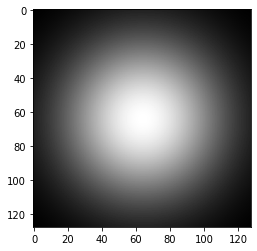

In [ ]:
n_grid = 128
xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
xi_match = xi / (n_grid//2) * abs_max # [-1,1)
Z_grid = griddata(points=XY,values=Z,xi=xi_match)

doplt(Z_grid.reshape(n_grid,n_grid))

# $O(?)$ in `len(xi)`

In [ ]:
for n_grid in [64,128,256,512,1024]:
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  %timeit griddata(points=XY,values=Z,xi=xi_match)
Z_grid = griddata(points=XY,values=Z,xi=xi_match)

10 loops, best of 3: 190 ms per loop
10 loops, best of 3: 193 ms per loop
10 loops, best of 3: 199 ms per loop
1 loop, best of 3: 220 ms per loop
1 loop, best of 3: 284 ms per loop


These doesn't seem to be much dependence on the grid size, perhaps a log scale dependence.

# $O(?)$ in `len(values)`

In [21]:
n_values_li = [10**x for x in [2,3,4,5,6]]
timings = np.zeros(len(n_values_li))
for idx,n_values in enumerate(n_values_li):
  np.random.seed(0)
  XY = np.random.multivariate_normal(mean=(0,0),cov=np.eye(2),size=n_values)
  percentile = np.percentile(np.abs(XY.flatten()),q=95)
  good_idx = (np.abs(XY) > percentile).sum(1)==0
  abs_max = np.abs(XY[good_idx]).max()
  Z = np.exp(-(XY**2).sum(1)/2)

  n_grid = 64
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  func1_time = %timeit -o griddata(points=XY,values=Z,xi=xi_match,method='linear')
  timings[idx] = func1_time.best

1000 loops, best of 3: 1.62 ms per loop
100 loops, best of 3: 12.9 ms per loop
10 loops, best of 3: 139 ms per loop
1 loop, best of 3: 1.76 s per loop
1 loop, best of 3: 20 s per loop


Text(0.5, 1.0, 'O(const * n_values) ; const = 20.1 us/value ')

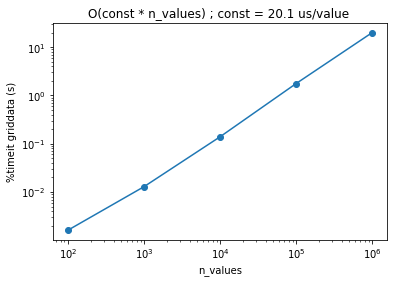

In [22]:
sr = pd.Series(timings)
sr.index = n_values_li
ax = sr.plot(marker='o',logx=True,logy=True)
ax.set_xlabel('n_values')
ax.set_ylabel('%timeit griddata (s)')
slope = (timings[-1] - timings[-3]) / (n_values_li[-1]-n_values_li[-3])
ax.set_title('O(const * n_values) ; const = %.1f us/value '%(slope*1e6))

For every extra value, griddata will take 24 to 27 us more. The trend it sublinear up to a few thousand for larger n_grid (256,512), but then become linear after that. And this is independent of the size of the grid onto which to sample it, which can be fine or coarse.

|d|n_grid|%timeit griddata (us/value)|
|-|-|-|
|2|64|26.5 |
|2| 128|25 |
|2|256|24.1|
|2|512|26.6|

# 3D Gaussian

In [ ]:
n_values=10**6
d=3
np.random.seed(0)
XYZ = np.random.multivariate_normal(mean=np.zeros(d),cov=np.eye(d),size=n_values)
percentile = np.percentile(np.abs(XYZ.flatten()),q=95)
good_idx = (np.abs(XYZ) > percentile).sum(1)==0
abs_max = np.abs(XYZ[good_idx]).max()
# XY = XY[good_idx]
F = np.exp(-(XYZ**2).sum(1)/2)

abs_max

1.9581565358354729

In [ ]:
n_grid = 512
xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=d) #/ (n_grid//2)
xi_match = xi / (n_grid//2) * abs_max # [-1,1)
F_grid = griddata(points=XYZ,values=F,xi=xi_match)



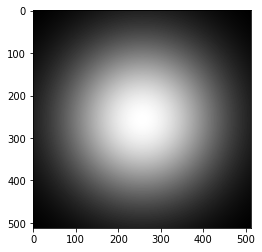

In [ ]:
doplt(np.nanmean(F_grid.reshape(n_grid,n_grid,n_grid),0))

The 3D interpolation is working. Let's see how this scales.

In [ ]:
n_values_li = [10**x for x in [2,3,4,5,6]]
timings = np.zeros(len(n_values_li))
for idx,n_values in enumerate(n_values_li):
  np.random.seed(0)
  XYZ = np.random.multivariate_normal(mean=np.zeros(d),cov=np.eye(d),size=n_values)
  percentile = np.percentile(np.abs(XYZ.flatten()),q=95)
  good_idx = (np.abs(XYZ) > percentile).sum(1)==0
  abs_max = np.abs(XYZ[good_idx]).max()
  F = np.exp(-(XYZ**2).sum(1)/2)

  n_grid = 512
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=d) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  griddata_time = %timeit -o griddata(points=XYZ,values=F,xi=xi_match,method='linear')
  timings[idx] = griddata_time.best

1 loop, best of 3: 7.59 s per loop
1 loop, best of 3: 9.01 s per loop
1 loop, best of 3: 10.8 s per loop
1 loop, best of 3: 21.8 s per loop
1 loop, best of 3: 1min 58s per loop


Text(0.5, 1.0, 'O(const * n_values) ; const = 108.0 us/value ')

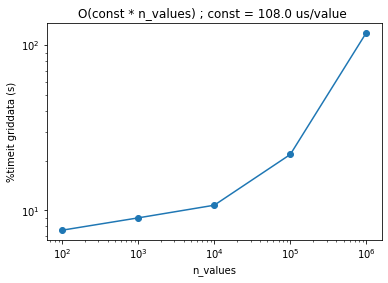

In [20]:
sr = pd.Series(timings)
sr.index = n_values_li
ax = sr.plot(marker='o',logx=True,logy=True)
ax.set_xlabel('n_values')
ax.set_ylabel('%timeit griddata (s)')
slope = (timings[-1] - timings[-2]) / (n_values_li[-1]-n_values_li[-2])
ax.set_title('O(const * n_values) ; const = %.1f us/value '%(slope*1e6))

In [19]:
timings[-1]/n_values_li[-1]

118.9763155339997

For every extra value, griddata will take 100 to 111 us more. The trend it sublinear up to a few thousand for larger n_grid (256,512), but then become linear after that. And this is independent of the size of the grid onto which to sample it, which can be fine or coarse.

|n_grid|%timeit griddata (us/value)|
|-|-|
| 64|100.5|
| 128| |
|256||
|512|108-111|

We can see now in 3D, the trend is the same, but the constant is larger. There still is practically no dependence on `n_grid`.



# Parralelization

When we are doing Fourier inversion, for a box size of N, and $n_p$ particles we would have $N^2n_p$ (complex) values on an $N^3$ sized grid. For 10k particles and $N \in \{64,126,256,512\}$ this would be \{41,163,655,2621\} million complex numbers to interpolate. Surely something parralelized and fast is doing this, and not griddata, which would take \{1.1,4.6,18,73\} hours.

Parralelization could be leveraged if the interpolated slices can just be added to each other. We could do the interpolations in batches in parallel, and then bring them together at the end. Essentially doing averages step by step.

* https://stackoverflow.com/questions/14015114/scipy-interpolate-griddata-equivalent-in-cuda
* https://dypy.readthedocs.io/en/latest/intergrid.html